### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта
## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 4


### Дисциплина: Методы машинного обучения
##### Студент:  Маслова Анастасия
##### Группа:   НКНбд-01-21
## Москва 2024
***
### Вариант №14

1. Набор данных: diamonds

2. Независимые признаки: depth, table

3. Метка класса: color

4. Показатель бинарной классификации:

𝐹𝑁 (False Negatives) – число точек в положительном классе, ошибочно спрогнозированных в отрицательный класс

5. Параметры нейронных сетей:

Кол-во скрытых слоев: 3

Кол-во нейронов в слое: 128

Оптимизаторы: Adadelta, AdamW, RMSprop

Функция активации в скрытых слоях: leaky_relu


Решение:


1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимые признаки и метку класса. Оставьте в наборе признаки, принимающие числовые значения.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import scipy as sp
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import roc_auc_score
import math

In [2]:
ds = tfds.load("diamonds", split="train")
df = tfds.as_dataframe(ds)
df.head()

,features/carat,features/clarity,features/color,features/cut,features/depth,features/table,features/x,features/y,features/z,price
0,1.26,2,4,2,60.599998,60.0,6.97,7.00,4.23,6546.0
1,0.80,3,4,4,62.099998,54.0,5.96,5.99,3.71,3030.0
2,0.56,4,2,4,61.700001,54.0,5.28,5.32,3.27,1915.0
3,1.51,3,6,1,64.000000,58.0,7.24,7.27,4.64,6936.0
4,0.33,6,5,4,62.200001,54.0,4.43,4.45,2.76,646.0


Все принимают числовые значения, ничего не трогаем.

2. Визуализируйте точки набора данных на плоскости с координатами, соответствующими двум независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

In [3]:
np.unique(df['features/color'])

array([0, 1, 2, 3, 4, 5, 6])

In [4]:
x_out = df[['features/table','features/depth']]
df_z = x_out.apply(scipy.stats.zscore)
z_score = 2.5
df2_out = df[(((df_z >= -z_score).sum(axis=1)==2) & ((df_z <= z_score).sum(axis=1)==2))]
df2_del = pd.concat([df[((df_z < -z_score).sum(axis=1)==1)], df[((df_z > z_score).sum(axis=1)==1)]])
perc = df2_del.shape[0]/x_out.shape[0]*100
print(f'Процент выбросов = {perc}%')


Процент выбросов = 3.7096774193548385%


In [5]:
df = df2_out

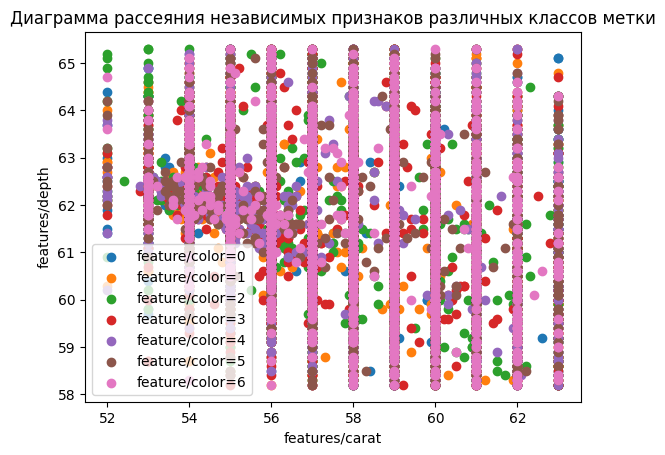

In [6]:
for i in range(7):
    df_tmp = df.loc[df['features/color'] == i]
    plt.scatter(df_tmp['features/table'], df_tmp['features/depth'],  label='feature/color=' + str(i))
plt.xlabel('features/carat')
plt.ylabel('features/depth')
plt.title('Диаграмма рассеяния независимых признаков различных классов метки')
plt.legend();

3. Если признак с метками классов содержит более двух классов, то объедините некоторые классы, чтобы получить набор для бинарной классификации. Объединяйте классы таким образом, чтобы положительный и отрицательный классы были сопоставимы по количеству точек.

In [7]:
df['features/color'].value_counts()

features/color
3    10990
1     9457
2     9175
4     8000
0     6566
5     5205
6     2679
Name: count, dtype: int64

In [8]:
df0 = pd.DataFrame()
df1 = pd.DataFrame()
for i in range(3):
    df_tmp = df.loc[df['features/color'] == i]
    df_tmp['features/color'] = 0
    df0 = pd.concat([df0, df_tmp])

for i in range(3, 7):
    df_tmp = df.loc[df['features/color'] == i]
    df_tmp['features/color'] = 1
    df1 = pd.concat([df1, df_tmp])
df_gen = pd.concat([df0, df1])
df_gen

<ipython-input-8-e94c1629d51b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['features/color'] = 0
<ipython-input-8-e94c1629d51b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['features/color'] = 1


,features/carat,features/clarity,features/color,features/cut,features/depth,features/table,features/x,features/y,features/z,price
25,0.50,3,0,3,62.799999,58.0,5.08,5.05,3.18,1845.0
31,0.60,1,0,3,61.299999,61.0,5.46,5.40,3.33,1428.0
44,0.71,1,0,4,61.000000,56.0,5.77,5.80,3.53,2505.0
49,1.01,2,0,4,61.400002,59.0,6.40,6.44,3.94,5812.0
51,0.31,5,0,4,60.900002,57.0,4.38,4.42,2.68,777.0
...,...,...,...,...,...,...,...,...,...,...
53858,2.00,2,1,3,62.200001,59.0,7.97,7.92,4.94,12308.0
53892,2.14,3,1,2,62.799999,57.0,8.27,8.16,5.16,14065.0
53897,2.10,6,1,3,61.299999,58.0,8.29,8.24,5.07,17606.0
53907,0.75,1,1,4,60.799999,57.0,5.91,5.87,3.58,1944.0


In [9]:
df_gen['features/color'].value_counts()

features/color
1    26874
0    25198
Name: count, dtype: int64

In [10]:
df_train = df_gen[['features/table', 'features/depth', 'features/color']]
df_train

,features/table,features/depth,features/color
25,58.0,62.799999,0
31,61.0,61.299999,0
44,56.0,61.000000,0
49,59.0,61.400002,0
51,57.0,60.900002,0
...,...,...,...
53858,59.0,62.200001,1
53892,57.0,62.799999,1
53897,58.0,61.299999,1
53907,57.0,60.799999,1


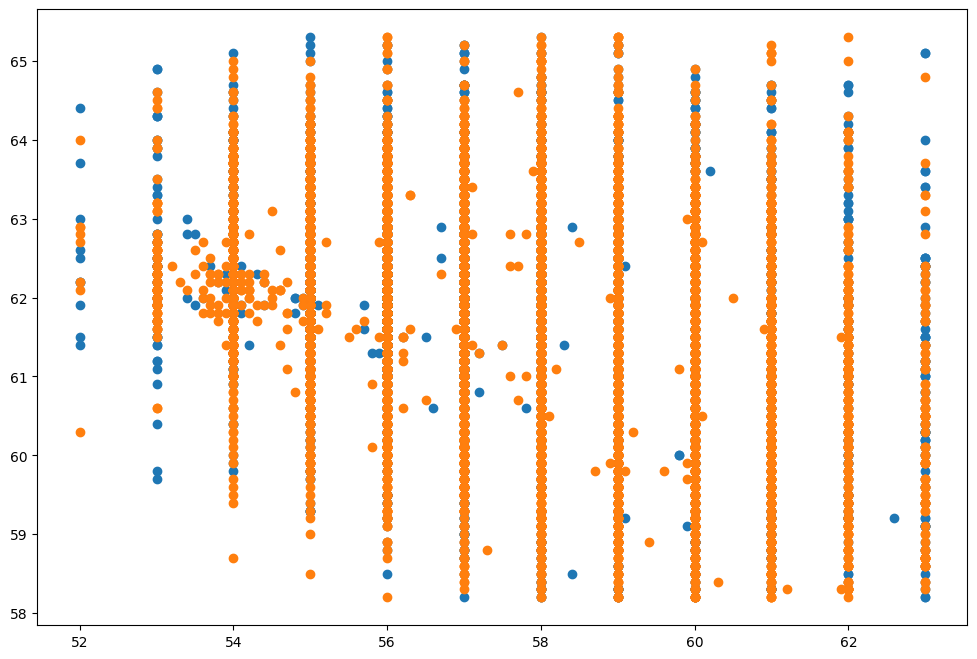

In [11]:
df_0 = df_train.loc[df['features/color'] == 0]
df_1 = df_train.loc[df['features/color'] == 1]
plt.figure(figsize=(12,8))
plt.scatter(df_0['features/table'], df_0['features/depth'])
plt.scatter(df_1['features/table'], df_1['features/depth'])

4. Разбейте набор данных из двух признаков и бинарных меток класса на обучающую и тестовую выборки. Постройте нейронные сети с нормализующим слоем и параметрами, указанными в индивидуальном задании, для бинарной классификации и обучите их на обучающей выборке, контролируя процесс обучения нейронных сетей. Определите нейронную сеть с более высоким качеством бинарной классификации по показателю бинарной классификации, указанному в индивидуальном задании.

Показатель бинарной классификации:

𝐹𝑁 (False Negatives) – число точек в положительном классе, ошибочно спрогнозированных в отрицательный класс

------------

Параметры нейронных сетей:

Кол-во скрытых слоев: 3

Кол-во нейронов в слое: 128

Оптимизаторы: Adadelta, AdamW, RMSprop

Функция активации в скрытых слоях: leaky_relu

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(True)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_gen[['features/table', 'features/depth']], df_gen['features/color'], test_size=0.3, random_state=1)
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(x_train)

In [14]:
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

In [15]:
model_1 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [16]:
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [17]:
history1 = model_1.fit(
    x_train, y_train,
    epochs=20,
    verbose=1,
    validation_split = 0.2)

Epoch 1/20
912/912 [==============================] - 4s 3ms/step - loss: 0.6949 - accuracy: 0.4930 - val_loss: 0.6937 - val_accuracy: 0.5110
Epoch 2/20
912/912 [==============================] - 3s 4ms/step - loss: 0.6916 - accuracy: 0.5264 - val_loss: 0.6928 - val_accuracy: 0.5158
Epoch 3/20
912/912 [==============================] - 3s 3ms/step - loss: 0.6912 - accuracy: 0.5291 - val_loss: 0.6927 - val_accuracy: 0.5178
Epoch 4/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6910 - accuracy: 0.5284 - val_loss: 0.6927 - val_accuracy: 0.5200
Epoch 5/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6909 - accuracy: 0.5294 - val_loss: 0.6927 - val_accuracy: 0.5193
Epoch 6/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6909 - accuracy: 0.5308 - val_loss: 0.6926 - val_accuracy: 0.5193
Epoch 7/20
912/912 [==============================] - 3s 3ms/step - loss: 0.6908 - accuracy: 0.5300 - val_loss: 0.6926 - val_accuracy: 0.5195
Epoch 

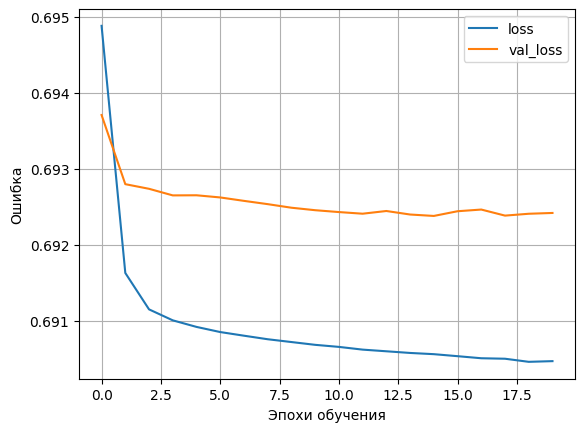

In [18]:
plot_loss(history1)

In [19]:
model_2 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [20]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.AdamW(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [21]:
history2 = model_2.fit(
    x_train, y_train,
    epochs=20,
    verbose=1,
    validation_split = 0.2)

Epoch 1/20
912/912 [==============================] - 4s 3ms/step - loss: 0.6943 - accuracy: 0.5174 - val_loss: 0.6945 - val_accuracy: 0.5134
Epoch 2/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6941 - accuracy: 0.5132 - val_loss: 0.6939 - val_accuracy: 0.5154
Epoch 3/20
912/912 [==============================] - 3s 3ms/step - loss: 0.6951 - accuracy: 0.5141 - val_loss: 0.6932 - val_accuracy: 0.5147
Epoch 4/20
912/912 [==============================] - 3s 4ms/step - loss: 0.6955 - accuracy: 0.5154 - val_loss: 0.6929 - val_accuracy: 0.5154
Epoch 5/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5156 - val_loss: 0.6932 - val_accuracy: 0.5158
Epoch 6/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6945 - accuracy: 0.5167 - val_loss: 0.6936 - val_accuracy: 0.5015
Epoch 7/20
912/912 [==============================] - 2s 3ms/step - loss: 0.6951 - accuracy: 0.5094 - val_loss: 0.7076 - val_accuracy: 0.5152
Epoch 

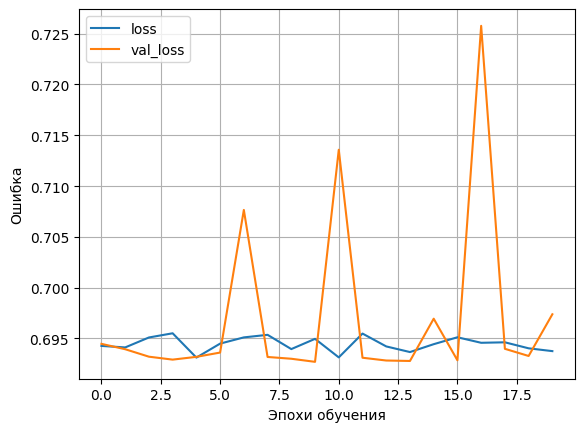

In [22]:
plot_loss(history2)

In [23]:
model_3 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [24]:
model_3.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.RMSprop(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [25]:
history3 = model_3.fit(
    x_train, y_train,
    epochs=20,
    verbose=1,
    validation_split = 0.2)

Epoch 1/20
912/912 [==============================] - 3s 3ms/step - loss: 0.6950 - accuracy: 0.5161 - val_loss: 0.6927 - val_accuracy: 0.5165
Epoch 2/20
912/912 [==============================] - 4s 4ms/step - loss: 0.6938 - accuracy: 0.5158 - val_loss: 0.6933 - val_accuracy: 0.5160
Epoch 3/20
912/912 [==============================] - 3s 3ms/step - loss: 0.6934 - accuracy: 0.5202 - val_loss: 0.6953 - val_accuracy: 0.5160
Epoch 4/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6938 - accuracy: 0.5199 - val_loss: 0.6925 - val_accuracy: 0.5170
Epoch 5/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6938 - accuracy: 0.5202 - val_loss: 0.6939 - val_accuracy: 0.4896
Epoch 6/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6942 - accuracy: 0.5231 - val_loss: 0.6984 - val_accuracy: 0.5170
Epoch 7/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6944 - accuracy: 0.5208 - val_loss: 0.6927 - val_accuracy: 0.5170
Epoch 

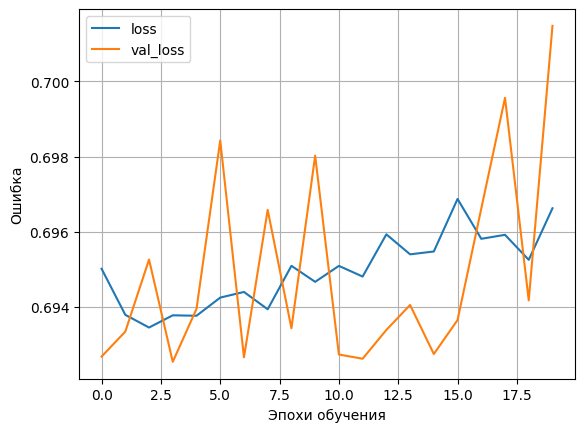

In [26]:
plot_loss(history3)

In [27]:
y_prediction1 = model_1.predict(x_train)
y_pred1 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction1)])
y_prediction2 = model_2.predict(x_train)
y_pred2 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction2)])
y_prediction3 = model_3.predict(x_train)
y_pred3 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction3)])

FN(y_pred1, np.array(y_train)), FN(y_pred2, np.array(y_train)), FN(y_pred3, np.array(y_train))

1140/1140 [==============================] - 2s 1ms/step


(13531, 17548, 10132)

FN - это число ошибочно спрогнозированных точек, поэтому побеждает модель, у которой этот показатель меньше, т.е. третья (model_3).

5. Визуализируйте границы принятия решений построенных нейронных сетей на отдельных рисунках на всем наборе данных из двух признаков и бинарных меток классов.

In [28]:
def plot_decision_boundary(model, X, y):
    # Найдем диапазоны изменения по осям и построим сетку
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Набор данных для прогнозирования
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Прогноз при помощи обученной модели
    y_pred = model.predict(X_in)
    # Проверка мультиклассовости
    if len(y_pred[1]) > 1:
        # мультиклассовая классификация
        # изменяем форму прогноза для визуализации
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        # бинарная классификация
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Рисуем границу решения
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 0s 1ms/step


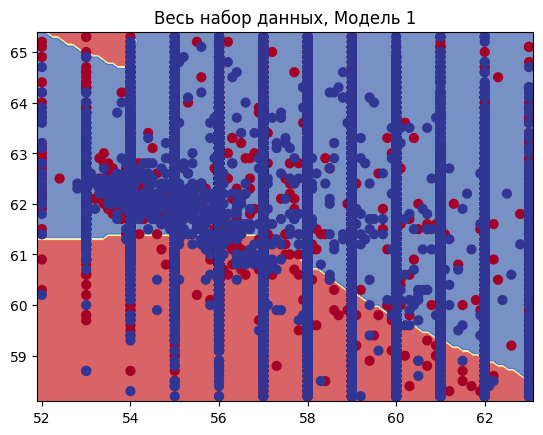

In [29]:
plt.title("Весь набор данных, Модель 1")
X = np.array(df_gen[['features/table', 'features/depth']])
y=df_gen['features/color']
plot_decision_boundary(model_1, X=X, y=y)

313/313 [==============================] - 0s 1ms/step


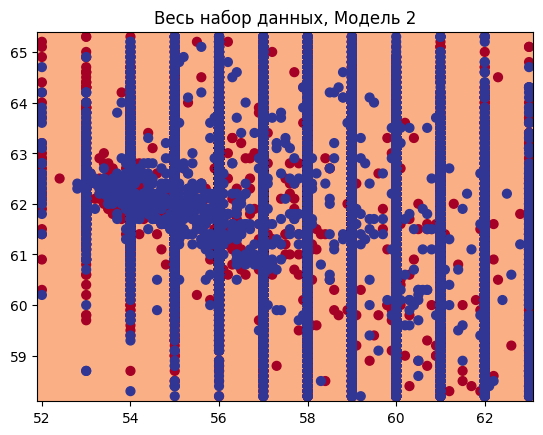

In [30]:
plt.title("Весь набор данных, Модель 2")
plot_decision_boundary(model_2, X=X, y=y)

313/313 [==============================] - 0s 1ms/step


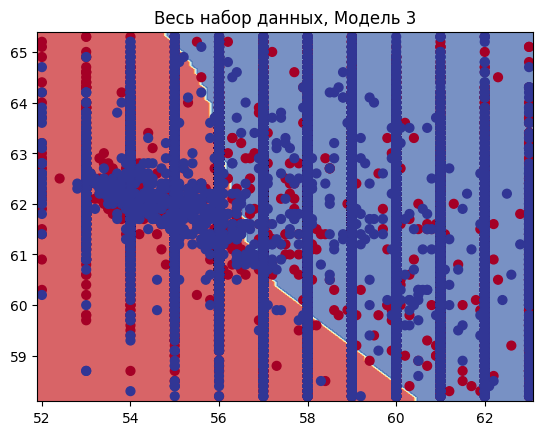

In [31]:
plt.title("Весь набор данных, Модель 3")
plot_decision_boundary(model_3, X=X, y=y)

6. Визуализируйте на одном рисунке ROC-кривые для построенных классификаторов на основе нейронных сетей, вычислите площади под ROC-кривыми методом трапеций или иным методом и создайте легенду с указанием площадей кривых.

In [32]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [33]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

1628/1628 [==============================] - 2s 1ms/step


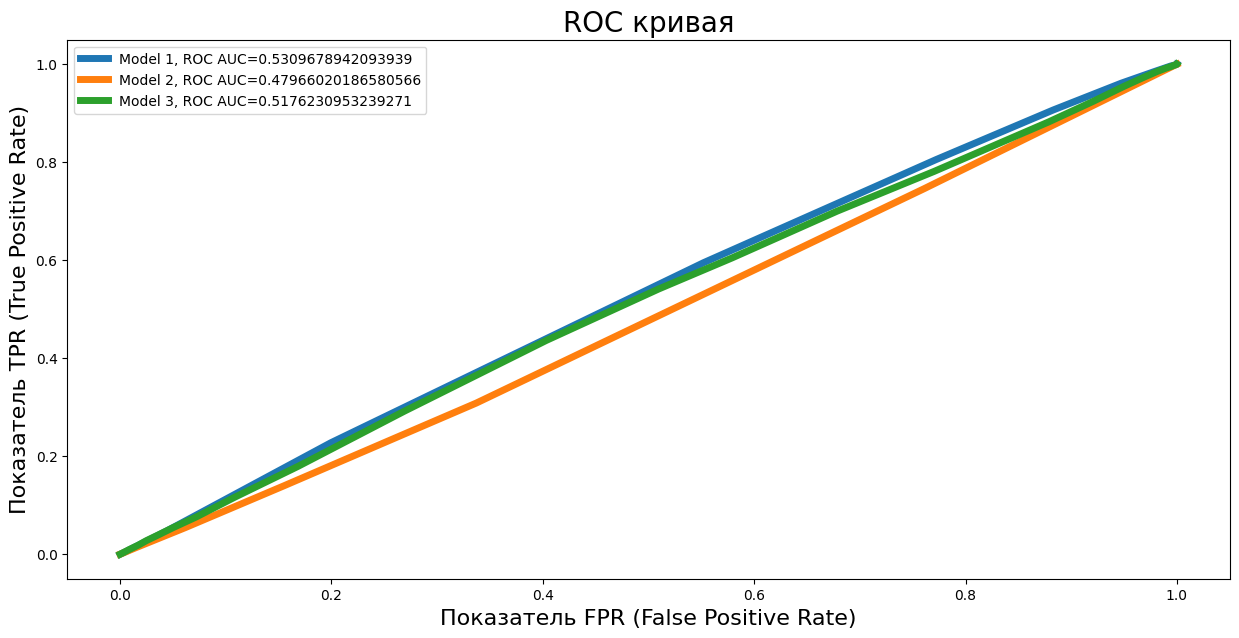

In [34]:
plt.figure(figsize=(15,7))
m1 = model_1.predict(X)
m2 = model_2.predict(X)
m3 = model_3.predict(X)
r1 = roc_auc_score(y, m1)
r2 = roc_auc_score(y, m2)
r3 = roc_auc_score(y, m3)
ROC1 = roc_from_scratch(m1.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC1[:,0],ROC1[:,1],lw=5, label='Model 1, ROC AUC=' + str(r1))
ROC2 = roc_from_scratch(m2.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC2[:,0],ROC2[:,1],lw=5, label='Model 2, ROC AUC=' + str(r2))
ROC3 = roc_from_scratch(m3.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC3[:,0],ROC3[:,1],lw=5, label='Model 3, ROC AUC=' + str(r3))
plt.title('ROC кривая',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16)
plt.legend();

7. Определите исходном наборе данных дополнительный признак, отличный от указанных в задании двух независимых признаков, принимающий непрерывные значения и имеющий максимальную дисперсию.

In [37]:
df_std = df_gen[['features/carat','features/x','features/y','features/z','price']].std()

In [38]:
df_std

features/carat       0.470888
features/x           1.120620
features/y           1.142859
features/z           0.704301
price             3996.285645
dtype: float32

price - признак с наибольшей дисперсией

8. Визуализируйте точки набора данных в трехмерном пространстве с координатами, соответствующими трем независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

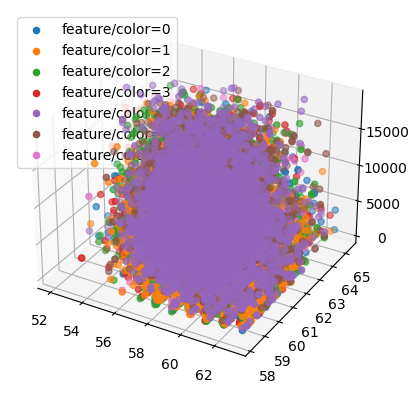

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(7):
    df_tmp = df.loc[df['features/color'] == i]
    ax.scatter(df_tmp['features/table'], df_tmp['features/depth'], df_tmp['price'],  label='feature/color=' + str(i))
ax.legend();

9. Разбейте исходный набор данных на обучающую и тестовую выборки. Постройте нейронную сеть для многоклассовой классификации с нормализующим слоем и параметрами, соответствующими лучшей нейронной сети для бинарной классифиации из п.4, и обучите ее на обучающей выборке, контролируя процесс ее обучения.


In [61]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

In [58]:
X = df[['features/table', 'features/depth', 'price']]
Y = list(df['features/color'])

In [59]:
for i in range(len(Y)):
    tmp = [0]*7
    tmp[Y[i]] = 1
    Y[i] = tmp
Y = np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [64]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

model_fin = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(128, activation = 'leaky_relu'),
    tf.keras.layers.Dense(7, activation = 'sigmoid')
])


model_fin.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.optimizers.RMSprop(),
    metrics = ['accuracy']
)

In [65]:
history = model_fin.fit(X_train, Y_train, epochs=80, verbose=1, validation_split = 0.3)

Epoch 1/80
798/798 [==============================] - 5s 4ms/step - loss: 1.8643 - accuracy: 0.2092 - val_loss: 1.8704 - val_accuracy: 0.2118
Epoch 2/80
798/798 [==============================] - 2s 3ms/step - loss: 1.8581 - accuracy: 0.2142 - val_loss: 1.8537 - val_accuracy: 0.2176
Epoch 3/80
798/798 [==============================] - 2s 3ms/step - loss: 1.8549 - accuracy: 0.2134 - val_loss: 1.8579 - val_accuracy: 0.2100
Epoch 4/80
798/798 [==============================] - 2s 3ms/step - loss: 1.8530 - accuracy: 0.2173 - val_loss: 1.8530 - val_accuracy: 0.2178
Epoch 5/80
798/798 [==============================] - 2s 3ms/step - loss: 1.8505 - accuracy: 0.2168 - val_loss: 1.8515 - val_accuracy: 0.2208
Epoch 6/80
798/798 [==============================] - 4s 5ms/step - loss: 1.8481 - accuracy: 0.2198 - val_loss: 1.8597 - val_accuracy: 0.2191
Epoch 7/80
798/798 [==============================] - 2s 3ms/step - loss: 1.8473 - accuracy: 0.2194 - val_loss: 1.8503 - val_accuracy: 0.2189
Epoch 

10. Постройте кривые обучения в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

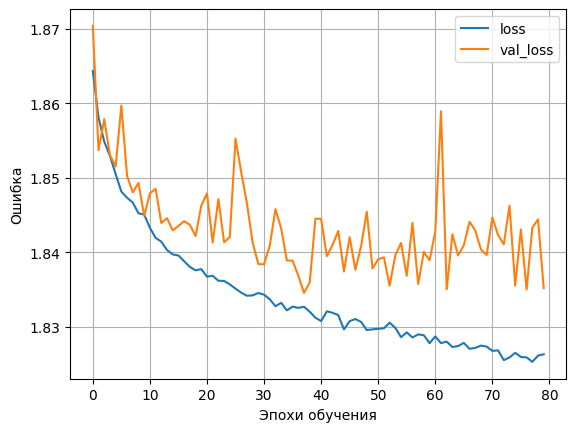

In [67]:
plot_loss(history)